In [1]:
import pandas as pd 
from bs4 import BeautifulSoup
from urllib.parse import quote
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

import re

In [2]:
topic = pd.read_csv('./관광지상세정보url_merge.csv')

In [3]:
topic.head(5)

,관광지명,주소,상세정보,해시태그_sub,평균별점,주소_동별,연락처,위도,경도,해시태그,상세페이지_url
0,성산일출봉(UNESCO 세계자연유산),제주특별자치도 서귀포시 성산읍 일출로 284-12,성산일출봉은 제주도의 다른 오름들과는 달리 마그마가 물속에서 분출하면서 만들어진 수...,"일출,오름,경관,포토,부모,자연경관,포토스팟,유네스코,무장애관광,공영관광지",별점(5점만점에 5점),성산읍 성산리,(+82) 064-783-0959,33.462234,126.936801,"['#일출', '#오름', '#경관/포토', '#부모', '#자연경관', '#포토스...",https://www.visitjeju.net/kr/detail/view?conte...
1,우도(해양도립공원),제주특별자치도 제주시 우도면 삼양고수물길 1,우도는 소가 누워있는 모양을 닮았다고 해서 일찍부터 소섬 또는 쉐섬으로 불리웠다. ...,"섬속의섬,경관,포토,아이,맑음,자연경관,포토스팟,어린이,봄꽃,유채꽃,유네스코,무장애...",별점(5점만점에 5점),우도면 연평리,(+82) 064-728-1527,33.519472,126.951017,"['#섬속의섬', '#경관/포토', '#아이', '#맑음', '#자연경관', '#포...",https://www.visitjeju.net/kr/detail/view?conte...
2,사려니숲길,제주특별자치도 제주시 조천읍 교래리 산 137-1,"사려니숲길은 제주의 숨은 비경 31곳 중 하나로, 비자림로를 시작으로 물찻오름과 사...","숲길,걷기,등산,친구,커플,흐림,봄,자연경관,도보여행,도보,숲,단풍,공영관광지",별점(5점만점에 5점),조천읍 교래리,(+82) 064-900-8800,33.407703,126.644672,"['#숲길', '#걷기/등산', '#친구', '#커플', '#흐림', '#봄', '...",https://www.visitjeju.net/kr/detail/view?conte...
3,카멜리아힐,제주 서귀포시 안덕면 병악로 166,"카멜리아힐은 동양에서 가장 큰 동백 수목원으로 토종 동백부터 아기 동백, 유럽 동백...","경관,포토,커플,아이,맑음,겨울,힐링,자연경관,포토스팟,어린이,어트랙션,동백,수국,...",별점(5점만점에 5점),안덕면 상창리,(+82) 064-800-6296,33.290140,126.368365,"['#경관/포토', '#커플', '#아이', '#맑음', '#겨울', '#힐링', ...",https://www.visitjeju.net/kr/detail/view?conte...
4,협재해수욕장,제주특별자치도 제주시 한림읍 한림로 329-10,"반려동물의 경우, 해수욕장 개장 기간 내 지정 해수욕장 유영 구역의 입욕은 통제됩니...","일몰,해수욕장,액티비티,아이,맑음,여름,자연경관,체험,레저,체험,해변,물놀이,어린이...",별점(5점만점에 5점),한림읍 협재리,(+82) 064-728-3981,33.393748,126.239432,"['#일몰', '#해수욕장', '#액티비티', '#아이', '#맑음', '#여름',...",https://www.visitjeju.net/kr/detail/view?conte...


In [4]:
topic['해시태그_sub'][0]

'일출,오름,경관,포토,부모,자연경관,포토스팟,유네스코,무장애관광,공영관광지'

In [5]:
web_stopwords = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()

stopwords = set([])
for i in web_stopwords:
    stopwords.add(i[0])

len(stopwords)


# 불용어 추가 (_5에서 '사유','봄봄','니스' 추가)
jeju_stopwords_5_2 = ['제주', '제주도',  '리뷰', '숙소', '여행', '트립', '정말', '동안', '다음', '바로', '근처', '조금', '시간',
                   '호스트', '정도', '방문', '사장', '이용', '다시', '예약', '살이', '살기', '아주', '추천', '하루', '이번',
                   '처음', '달동', '저희', '하나', '사용', '모두', '진짜', '일주일', '보름', '선택', '시작', '한번', '가장', '마음',
                   '제외', '이동', '무엇', '준비', '그냥', '감사', '생각', '느낌', '덕분', '후기', '기회',  '다른', '여기', '우리',
                   '미스터', '미스터멘션', '멘션', '때문', '오늘', '도착', '보고', '마지막', '가지', '이제', '지금', '모습', '위해',
                   '타고', '사실', '포스팅', '주문', '역시', '침대', '거실', '매일', '출발', '소개', '기억', '참고', '계속', '객실',
                   '일차', '이야기', '요즘', '이유', '경우', '일단', '거의', '스텝', '제일', '자주', '어디', '마무리', '아래', '운영',
                   '이상', '의자', '별로', '원래', '중간', '뭔가', '첫째', '체크', '잠시', '언제', '살짝', '해도', '계단', '부분', '냉장고',
                    '침실', '기본', '제공', '일찍', '인테리어', '완전', '추가', '등등', '매우', '가야', '그때', '기간', '마치', '가득', '대부분',
                    '미리', '둘째', '근무', '공간', '스테이', '알파', '엄마', '아빠', '아들', '일정', '계획', '아침',
                     '점심', '저녁', '자리', '두리', '언니', '가격', '건물', '언니', 
                      '숙박', '만원', '가기', '독채','화장실', '욕실', '숙박', '세탁기', '코로나' ,'사유','봄봄','니스',
                     '주방', '도서관', '서울','티비', '트랙','이드','택트','입장','가가','업체','아이비','반입','돼지','관문','우수','연경',
                     '호텔', '펜션', '게스트하우스', '반려동물']
for word in jeju_stopwords_5_2:
    stopwords.add(word)

In [6]:
from konlpy.tag import Okt
from collections import Counter
okt = Okt()

In [7]:
def hangul_function(text):
    hangul = re.compile('[^ ㄱ-ㅣ 가-힣]')  # 한글 추출 규칙: 띄어 쓰기(1 개)를 포함한 한글
    result = hangul.sub('', text)  # 위에 설정한 "hangul"규칙을 "text"에 적용(.sub)시킴
    return result

In [8]:
temp_list = []
for blog in topic['해시태그_sub']:
    LDA_nous = okt.nouns(hangul_function(blog))
    LDA_nous = [x for x in LDA_nous if len(x) > 1 or x =='봄']  # 한글자 키워드 제거    
    LDA_nous = [word for word in LDA_nous if not word in stopwords]
    temp_list.append(LDA_nous)

In [9]:
from gensim.models.ldamodel import LdaModel
from gensim.models.callbacks import CoherenceMetric
from gensim import corpora
from gensim.models.callbacks import PerplexityMetric

import pickle
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [10]:
# num_topics를 6에서 5로 수정(topic_2까지는 6개로 분석).


temp_list = []
for blog in topic['해시태그_sub']:
    LDA_nous = okt.nouns(hangul_function(blog))
    LDA_nous = [x for x in LDA_nous if len(x) > 1 or x =='봄']  # 한글자 키워드 제거    
    LDA_nous = [word for word in LDA_nous if not word in stopwords]
    temp_list.append(LDA_nous)

dictionary = corpora.Dictionary(temp_list)
dictionary.filter_extremes(no_below=2, no_above=0.5)
corpus_test = [dictionary.doc2bow(text) for text in temp_list]

num_topics = 5
#각 학습청크에서 한번에 처리되는 문서의 수. 값이 클수록 훈련속도 up많은 메모리 필요할수도 있음.
# 값이 작을수록 더 정확한 결과를 얻을 수 있지만 훈련속도가 느려질수 있고 일반적인 값은 약 2000
chunksize = 2000 
# 학습중에 전체 말뭉치가 처리되는 횟수. 패스 수를 늘리면 더 정확한 모델을 만들 수 있지만 더 많은
# 더 많은  계산이 필요함. 일반적인 값은 약20.
passes = 20
#  각 패스내에서 모델 매개변수를 업데이트하기 위한 반복횟수. 일반적인 값은 약 400
iterations = 400
#  지정된 경우 모델 당혹도는 반복마다 평가됨. 복잡도는 모형이 보류된 테스트 세트를 얼마나 잘 예측하는지를
# 측정한 것. 이 매개변수를 설정하면 모델의 수렴을 모니터링하는데 도움이 될수있음.
#  'None'인 경우, 훈련 중에 복잡도가 계산되지 않음.
eval_every = None


temp = dictionary[0]
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus_test,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

lda_visualization = gensimvis.prepare(model, corpus_test, dictionary, sort_topics=True,)
pyLDAvis.save_html(lda_visualization, './result/topicmodeling3_5_test.html')

In [11]:
top_topics = model.top_topics(corpus_test)

avg_topic_coherence = sum([t[1] for t in top_topics])/ num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

Average topic coherence: -7.8850.
[([(0.12231081, '경관'),
   (0.10201813, '포토'),
   (0.06255351, '커플'),
   (0.059333492, '자연'),
   (0.05859284, '맑음'),
   (0.05264644, '스팟'),
   (0.048145525, '휴식'),
   (0.04431985, '친구'),
   (0.042231686, '힐링'),
   (0.034427505, '부모'),
   (0.02887418, '어린이'),
   (0.027778799, '해변'),
   (0.023499805, '관광지'),
   (0.02178535, '여름'),
   (0.018375663, '관광'),
   (0.013438598, '무장애'),
   (0.010544726, '사계절'),
   (0.010159043, '치유'),
   (0.009287029, '일몰'),
   (0.009196436, '동반')],
  -1.9640202260200579),
 ([(0.24029605, '체험'),
   (0.088101156, '레저'),
   (0.06810603, '관광'),
   (0.032705046, '마을'),
   (0.032586206, '어린이'),
   (0.032353822, '맑음'),
   (0.031106958, '커플'),
   (0.028760584, '친구'),
   (0.025913943, '수상'),
   (0.023412094, '이색'),
   (0.0180198, '관광지'),
   (0.017037332, '산책'),
   (0.014864117, '애견'),
   (0.013396931, '승마'),
   (0.013360377, '해변'),
   (0.013118253, '물놀이'),
   (0.012189652, '여름'),
   (0.0115959495, '동반'),
   (0.010931388, '캠핑'),
   (0.010

In [12]:
df_topic = pd.DataFrame(model.print_topics(num_words=20))
df_topic.columns = ['group', 'topic']
df_topic


,group,topic
0,0,"0.182*""도보"" + 0.077*""걷기"" + 0.077*""자연"" + 0.073*""..."
1,1,"0.122*""경관"" + 0.102*""포토"" + 0.063*""커플"" + 0.059*""..."
2,2,"0.063*""실내"" + 0.062*""카페"" + 0.054*""관광지"" + 0.050*..."
3,3,"0.240*""체험"" + 0.088*""레저"" + 0.068*""관광"" + 0.033*""..."
4,4,"0.190*""문화"" + 0.110*""유적지"" + 0.105*""관광"" + 0.099*..."


In [13]:
temp = df_topic['topic'].str.split('+', expand=True)
for i in range(20):    
    temp.rename(columns= {i: f'topic_{i}'}, inplace= True)
    temp[[f'topic_{i}_rate', f'topic_{i}_key']] = temp[f'topic_{i}'].str.split('*', expand=True)
    temp.drop(columns= f'topic_{i}', inplace=True)
    temp[f'topic_{i}_key'] = temp[f'topic_{i}_key'].apply(lambda x: x.replace('"', ''))

In [14]:
temp.reset_index(inplace=True)
temp.rename(columns={'index' : 'group'}, inplace=True)
temp

,group,topic_0_rate,topic_0_key,topic_1_rate,topic_1_key,topic_2_rate,topic_2_key,topic_3_rate,topic_3_key,topic_4_rate,...,topic_15_rate,topic_15_key,topic_16_rate,topic_16_key,topic_17_rate,topic_17_key,topic_18_rate,topic_18_key,topic_19_rate,topic_19_key
0,0,0.182,도보,0.077,걷기,0.077,자연,0.073,등산,0.069,...,0.011,와이파이존,0.009,보호,0.008,가을,0.008,단체,0.008,가족
1,1,0.122,경관,0.102,포토,0.063,커플,0.059,자연,0.059,...,0.013,무장애,0.011,사계절,0.010,치유,0.009,일몰,0.009,동반
2,2,0.063,실내,0.062,카페,0.054,관광지,0.050,라떼,0.048,...,0.013,사계절,0.011,바닐라,0.011,어린이,0.011,겨울,0.010,안전
3,3,0.240,체험,0.088,레저,0.068,관광,0.033,마을,0.033,...,0.013,물놀이,0.012,여름,0.012,동반,0.011,캠핑,0.011,무장애
4,4,0.190,문화,0.110,유적지,0.105,관광,0.099,역사,0.099,...,0.007,치즈,0.006,도로,0.006,명품,0.005,서귀포시,0.005,제주시


In [15]:
topic_240115_5_test= temp

In [21]:
# topic_240115_5_2 = pd.DataFrame(top_topics, columns=['Coherence Score', 'Representative Words'])

In [16]:
topic_240115_5_test.to_csv('./240115_topic_5_test.csv', index=False)

In [17]:
pd.read_csv('./240115_topic_5_test.csv')

,group,topic_0_rate,topic_0_key,topic_1_rate,topic_1_key,topic_2_rate,topic_2_key,topic_3_rate,topic_3_key,topic_4_rate,...,topic_15_rate,topic_15_key,topic_16_rate,topic_16_key,topic_17_rate,topic_17_key,topic_18_rate,topic_18_key,topic_19_rate,topic_19_key
0,0,0.182,도보,0.077,걷기,0.077,자연,0.073,등산,0.069,...,0.011,와이파이존,0.009,보호,0.008,가을,0.008,단체,0.008,가족
1,1,0.122,경관,0.102,포토,0.063,커플,0.059,자연,0.059,...,0.013,무장애,0.011,사계절,0.010,치유,0.009,일몰,0.009,동반
2,2,0.063,실내,0.062,카페,0.054,관광지,0.050,라떼,0.048,...,0.013,사계절,0.011,바닐라,0.011,어린이,0.011,겨울,0.010,안전
3,3,0.240,체험,0.088,레저,0.068,관광,0.033,마을,0.033,...,0.013,물놀이,0.012,여름,0.012,동반,0.011,캠핑,0.011,무장애
4,4,0.190,문화,0.110,유적지,0.105,관광,0.099,역사,0.099,...,0.007,치즈,0.006,도로,0.006,명품,0.005,서귀포시,0.005,제주시


클러스터링!!

In [18]:
# !pip install matplotlib seaborn sklearn konlpy scikit-learn wordcloud pyLDAvis gensim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

from wordcloud import WordCloud, STOPWORDS

from konlpy.tag import Okt
okt = Okt() 
from collections import Counter

In [19]:
topic = pd.read_csv('./관광지상세정보url_merge.csv')

In [20]:
stopwords = set([])

web_stopwords = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()
web_stopwords[:10]

for i in web_stopwords:
    stopwords.add(i[0])

print(len(stopwords))

# 불용어 추가 (_5에서 '사유','봄봄','니스' 추가)
jeju_stopwords_5_2 = ['제주', '제주도',  '리뷰', '숙소', '여행', '트립', '정말', '동안', '다음', '바로', '근처', '조금', '시간',
                   '호스트', '정도', '방문', '사장', '이용', '다시', '예약', '살이', '살기', '아주', '추천', '하루', '이번',
                   '처음', '달동', '저희', '하나', '사용', '모두', '진짜', '일주일', '보름', '선택', '시작', '한번', '가장', '마음',
                   '제외', '이동', '무엇', '준비', '그냥', '감사', '생각', '느낌', '덕분', '후기', '기회',  '다른', '여기', '우리',
                   '미스터', '미스터멘션', '멘션', '때문', '오늘', '도착', '보고', '마지막', '가지', '이제', '지금', '모습', '위해',
                   '타고', '사실', '포스팅', '주문', '역시', '침대', '거실', '매일', '출발', '소개', '기억', '참고', '계속', '객실',
                   '일차', '이야기', '요즘', '이유', '경우', '일단', '거의', '스텝', '제일', '자주', '어디', '마무리', '아래', '운영',
                   '이상', '의자', '별로', '원래', '중간', '뭔가', '첫째', '체크', '잠시', '언제', '살짝', '해도', '계단', '부분', '냉장고',
                    '침실', '기본', '제공', '일찍', '인테리어', '완전', '추가', '등등', '매우', '가야', '그때', '기간', '마치', '가득', '대부분',
                    '미리', '둘째', '근무', '공간', '스테이', '알파', '엄마', '아빠', '아들', '일정', '계획', '아침',
                     '점심', '저녁', '자리', '두리', '언니', '가격', '건물', '언니', 
                      '숙박', '만원', '가기', '독채','화장실', '욕실', '숙박', '세탁기', '코로나' ,'사유','봄봄','니스',
                     '주방', '도서관', '서울','티비', '트랙','이드','택트','입장','가가','업체','아이비','반입','돼지','관문','우수','연경',
                     '호텔', '펜션', '게스트하우스', '반려동물']
for word in jeju_stopwords_5_2:
    stopwords.add(word)

594


In [21]:
from sklearn.feature_extraction.text import CountVectorizer

def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ 가-힣]')  # 정규 표현식 처리
    result = hangul.sub('', text)
    okt = Okt()  # 형태소 추출
    nouns = okt.nouns(result)
    nouns = [x for x in nouns if len(x) > 1 or x =='봄']  # 한글자 키워드 제거
    nouns = [x for x in nouns if x not in stopwords]  # 불용어 제거
    return nouns

vect = CountVectorizer(tokenizer = lambda x: text_cleaning(x))
bow_vect = vect.fit_transform(topic['해시태그_sub'].tolist())
word_list = vect.get_feature_names_out()
count_list = bow_vect.toarray().sum(axis=0)

c:\Python39\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [15]:
word_list

array(['가가', '가능', '가든', ..., '휴양', '휴양림', '힐링'], dtype=object)

In [22]:
columns = []
for k, v in sorted(vect.vocabulary_.items(), key=lambda item:item[1]): 
  columns.append(k)

df = pd.DataFrame(bow_vect.toarray(), columns = columns) # DTM 만들기
df_tdm = df.T

In [23]:
df_tdm

,0,1,2,3,4,5,6,7,8,9,...,1474,1475,1476,1477,1478,1479,1480,1481,1482,1483
가능,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
가든,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
가라아게,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
가빈,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
가야금,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
훈제,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
휴식,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
휴양,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
휴양림,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
import matplotlib.pyplot as plt
plt.rc('font', family='malgun Gothic')

In [25]:
df_tdm['total'] = df_tdm.sum(axis=1)     # 단어 총 빈도수 계산
df_words = df_tdm[df_tdm['total'].rank(ascending=False) <= 50] # 빈도수 상위 50개 추출
df_words= df_words.drop('total', axis=1)    # 컬럼 'total' 제거
df_words[:5]

,0,1,2,3,4,5,6,7,8,9,...,1474,1475,1476,1477,1478,1479,1480,1481,1482,1483
가을,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
걷기,0,0,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
겨울,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
경관,2,2,1,2,1,1,2,1,1,2,...,0,0,0,2,0,0,1,2,0,0
공영,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [26]:
from scipy.cluster.hierarchy import linkage, dendrogram
from matplotlib import pyplot as plt

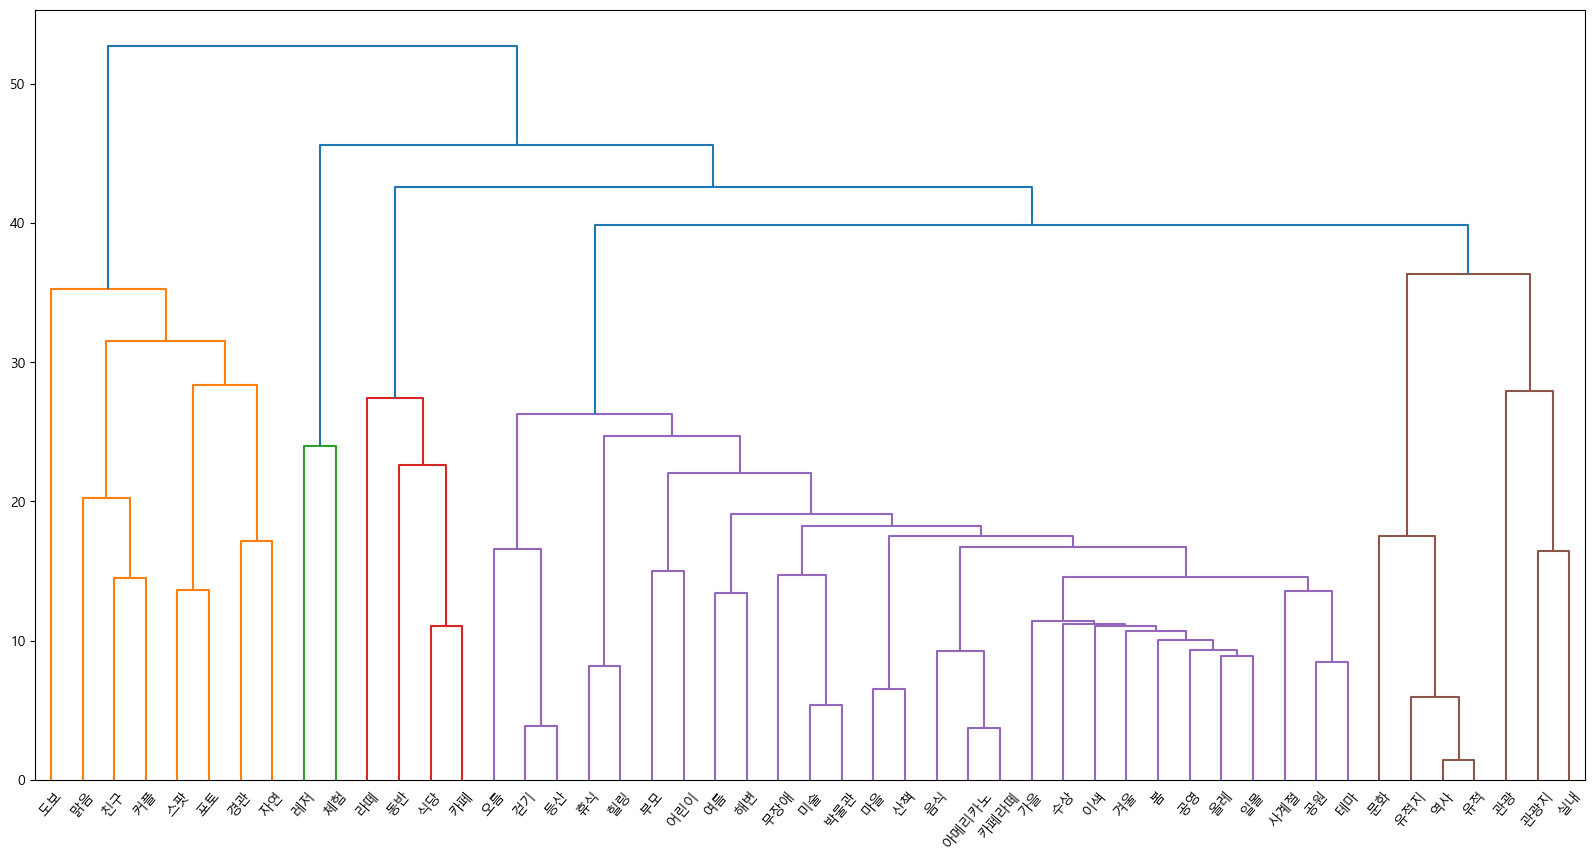

In [27]:
# 군집 방식은 ward로 거리는 유크리디안으로 측정해 군집분석

clusters = linkage(df_words, method='ward', metric='euclidean')

# 덴드로그램 그리기

plt.figure(figsize=(20, 10))               # 이미지 크기 설정
dendrogram(clusters,
           leaf_rotation=50,               # 라벨 50% 기울리기
           leaf_font_size=10,              # 라벨 폰트 크기
           labels=df_words.index)          # 라벨에 사용할 변수
plt.savefig('./result/240115_hier_5_test.png')

In [29]:
from sklearn.cluster import AgglomerativeClustering

ward = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
predict = ward.fit_predict(df_words)      # 군집 3개 분리값(0, 1, 2)
df_words['predict'] = predict             # 해당 군집값(0, 1, 2)을 원본 데이터에 붙이기
df_words[:5]

c:\Python39\lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


,0,1,2,3,4,5,6,7,8,9,...,1475,1476,1477,1478,1479,1480,1481,1482,1483,predict
가을,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,4
걷기,0,0,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,4
겨울,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
경관,2,2,1,2,1,1,2,1,1,2,...,0,0,2,0,0,1,2,0,0,1
공영,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4


In [30]:
cluster_1 = df_words[df_words['predict'] == 0].index
print("군집 1: ", cluster_1)
cluster_2 = df_words[df_words['predict'] == 1].index
print("군집 2: ", cluster_2)
cluster_3 = df_words[df_words['predict'] == 2].index
print("군집 3: ", cluster_3)
cluster_4 = df_words[df_words['predict'] == 3].index
print("군집 4: ", cluster_4)
cluster_5 = df_words[df_words['predict'] == 4].index
print("군집 5: ", cluster_5)
# cluster_6 = df_words[df_words['predict'] == 5].index
# print("군집 6: ", cluster_6)
# cluster_7 = df_words[df_words['predict'] == 6].index
# print("군집 7: ", cluster_7)

군집 1:  Index(['관광', '관광지', '문화', '실내', '역사', '유적', '유적지'], dtype='object')
군집 2:  Index(['경관', '도보', '맑음', '스팟', '자연', '친구', '커플', '포토'], dtype='object')
군집 3:  Index(['레저', '체험'], dtype='object')
군집 4:  Index(['동반', '라떼', '식당', '카페'], dtype='object')
군집 5:  Index(['가을', '걷기', '겨울', '공영', '공원', '등산', '마을', '무장애', '미술', '박물관', '봄', '부모',
       '사계절', '산책', '수상', '아메리카노', '어린이', '여름', '오름', '올레', '음식', '이색', '일몰',
       '카페라떼', '테마', '해변', '휴식', '힐링'],
      dtype='object')


In [31]:
temp_hier = []
for i in range(5):
    temp = i, df_words[df_words['predict'] == i].index.to_list()
    temp_hier.append(temp)

df_hier = pd.DataFrame(temp_hier)
df_hier.columns = ['group', 'keyword']
df_hier 

,group,keyword
0,0,"[관광, 관광지, 문화, 실내, 역사, 유적, 유적지]"
1,1,"[경관, 도보, 맑음, 스팟, 자연, 친구, 커플, 포토]"
2,2,"[레저, 체험]"
3,3,"[동반, 라떼, 식당, 카페]"
4,4,"[가을, 걷기, 겨울, 공영, 공원, 등산, 마을, 무장애, 미술, 박물관, 봄, ..."


In [33]:
df_hier.to_csv('./result/240115_hier_5_test.csv', index= False)

k-means

In [34]:
### K - Means
df_tdm['total'] = df_tdm.sum(axis=1)     # 단어 총 빈도수 계산
df_words = df_tdm[df_tdm['total'].rank(ascending=False) <= 50] # 빈도수 상위 50개 추출
df_words= df_words.drop('total', axis=1)    # 컬럼 'total' 제거
df_words[:5]

,0,1,2,3,4,5,6,7,8,9,...,1474,1475,1476,1477,1478,1479,1480,1481,1482,1483
가을,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
걷기,0,0,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
겨울,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
경관,2,2,1,2,1,1,2,1,1,2,...,0,0,0,2,0,0,1,2,0,0
공영,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [35]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters= 5)   # default: euclidean 거리
predict = kmeans.fit_predict(df_words)    # k-means 분석으로 군집 3개 분리(0, 1, 2)     
df_words['predict'] = predict             # 해당 군집값(0, 1, 2)을 원본 데이터에 붙이기
print(df_words[:5])

    0  1  2  3  4  5  6  7  8  9  ...  1475  1476  1477  1478  1479  1480  \
가을  0  0  0  0  0  0  0  1  0  1  ...     0     0     0     0     0     0   
걷기  0  0  1  0  0  0  0  1  1  0  ...     0     0     0     0     0     0   
겨울  0  0  0  1  0  0  0  0  0  0  ...     0     0     0     0     0     0   
경관  2  2  1  2  1  1  2  1  1  2  ...     0     0     2     0     0     1   
공영  1  1  1  0  0  0  0  0  0  1  ...     0     0     0     0     0     0   

    1481  1482  1483  predict  
가을     0     0     0        1  
걷기     0     0     0        1  
겨울     0     0     0        1  
경관     2     0     0        4  
공영     0     0     0        1  

[5 rows x 1485 columns]


c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [36]:
# 주성분 분석(PCA)을 이용해 단어별 x, y 좌표 얻기

from sklearn.decomposition import PCA

pca = PCA(n_components=2)                         # 2차원 PCA 모델 설정
word_pca = pca.fit_transform(df_words.iloc[0:, :-1])    # 군집 변수('predict')를 제외하고 PCA 실행)
df_pca = pd.DataFrame(data=word_pca, index=[df_words.index], columns=['main1', 'main2'])
df_pca['predict']= predict
df_pca.tail()

,main1,main2,predict
테마,-2.766825,1.154608,1
포토,14.655662,-1.046758,4
해변,0.909535,-0.455090,1
휴식,1.699466,0.001297,1
힐링,0.357437,-0.429199,1


c:\Python39\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
c:\Python39\lib\site-packages\seaborn\utils.py:84: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
C:\Users\tjoeun\AppData\Local\Temp\ipykernel_25592\1233488643.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(df_pca.main1[i], df_pca.main2[i], index)
C:\Users\tjoeun\AppData\Local\Temp\ipykernel_25592\1233488643.py:10: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('./result/240115_kmeans_5_test.png')
c:\Python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figu

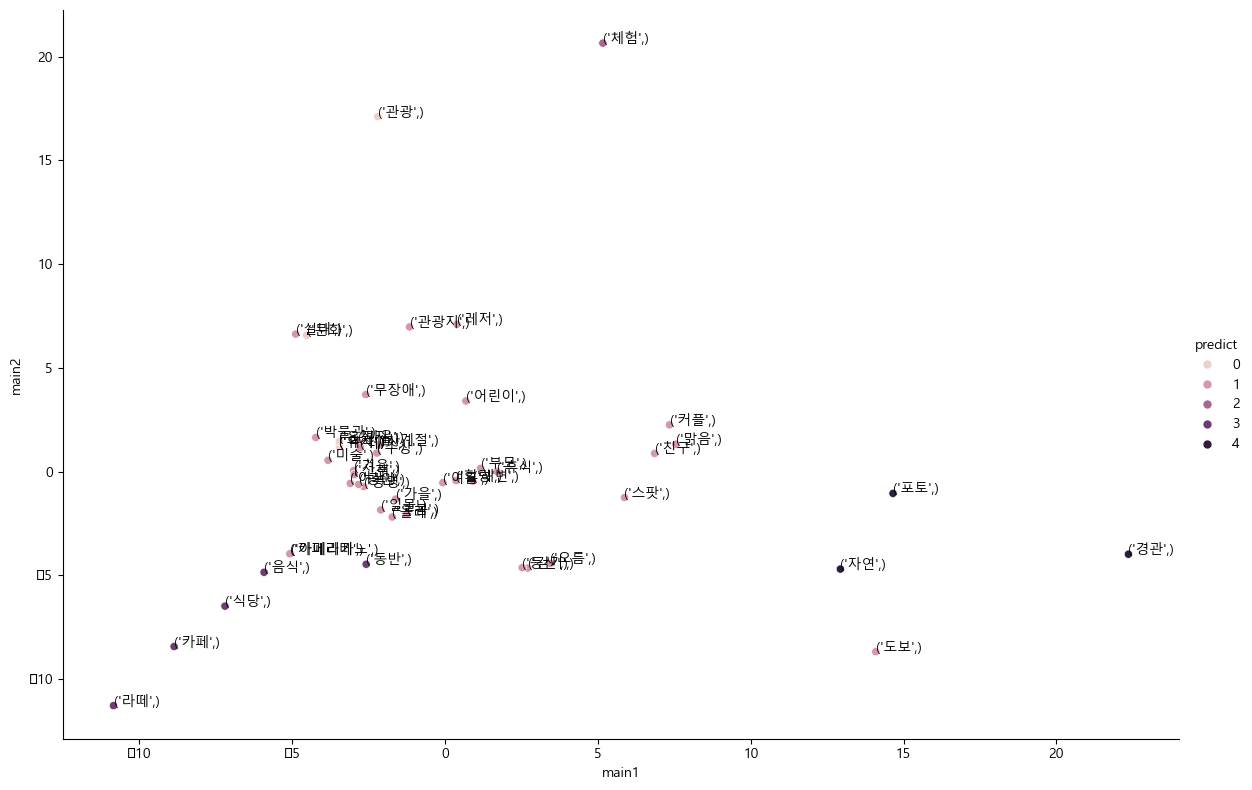

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# seaborn을 이용해 산점도 그리기
sns.relplot(data = df_pca, x='main1',y= 'main2', height =8, aspect=1.5, hue='predict') 

# 산점도에 라벨링하기
for i, index in enumerate(df_pca.index):
  plt.text(df_pca.main1[i], df_pca.main2[i], index)
plt.savefig('./result/240115_kmeans_5_test.png')

In [38]:
cluster_1 = df_pca[df_pca['predict'] == 0].index
print("군집 1: ", cluster_1)
cluster_2 = df_pca[df_pca['predict'] == 1].index
print("군집 2: ", cluster_2)
cluster_3 = df_pca[df_pca['predict'] == 2].index
print("군집 3: ", cluster_3)
cluster_4 = df_pca[df_pca['predict'] == 3].index
print("군집 4: ", cluster_4)
cluster_5 = df_pca[df_pca['predict'] == 4].index
print("군집 5: ", cluster_5)
# cluster_6 = df_pca[df_pca['predict'] == 5].index
# print("군집 6: ", cluster_6)

군집 1:  MultiIndex([( '관광',),
            ( '문화',),
            ( '역사',),
            ( '유적',),
            ('유적지',)],
           )
군집 2:  MultiIndex([(   '가을',),
            (   '걷기',),
            (   '겨울',),
            (   '공영',),
            (   '공원',),
            (  '관광지',),
            (   '도보',),
            (   '등산',),
            (   '레저',),
            (   '마을',),
            (   '맑음',),
            (  '무장애',),
            (   '미술',),
            (  '박물관',),
            (    '봄',),
            (   '부모',),
            (  '사계절',),
            (   '산책',),
            (   '수상',),
            (   '스팟',),
            (   '실내',),
            ('아메리카노',),
            (  '어린이',),
            (   '여름',),
            (   '오름',),
            (   '올레',),
            (   '이색',),
            (   '일몰',),
            (   '친구',),
            ( '카페라떼',),
            (   '커플',),
            (   '테마',),
            (   '해변',),
            (   '휴식',),
            (   '힐링',)],
           )
군집 3:  M

In [39]:
temp_kmean = []
for i in range(5):
    temp = i, df_words[df_words['predict'] == i].index.to_list()
    temp_kmean.append(temp)

df_kmean = pd.DataFrame(temp_kmean)
df_kmean.columns = ['group', 'keyword']
df_kmean 

,group,keyword
0,0,"[관광, 문화, 역사, 유적, 유적지]"
1,1,"[가을, 걷기, 겨울, 공영, 공원, 관광지, 도보, 등산, 레저, 마을, 맑음, ..."
2,2,[체험]
3,3,"[동반, 라떼, 식당, 음식, 카페]"
4,4,"[경관, 자연, 포토]"


In [40]:
df_kmean.to_csv('./result/240115_kmeans_5_test.csv', index=False)